A notebook for generating tables of single cell results when we group all cells of a single type together

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import glob
import itertools
from pathlib import Path
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from janelia_core.stats.multiple_comparisons import apply_by
from janelia_core.stats.multiple_comparisons import apply_bonferroni
from janelia_core.stats.regression import visualize_coefficient_stats

In [3]:
%matplotlib notebook

### Parameters go here 

In [4]:
# Specify folders where raw results for all analyses are
base_folders = [r'/Volumes/bishoplab/projects/keller_vnc/results/single_cell/publication_results_v1/a00c', 
                r'/Volumes/bishoplab/projects/keller_vnc/results/single_cell/publication_results_v1/basin',
                r'/Volumes/bishoplab/projects/keller_vnc/results/single_cell/publication_results_v1/handle']
                
# File where table should be saved
save_file= r'/Volumes/bishoplab/projects/keller_vnc/results/single_cell/publication_results_v1/all_segment_results.xlsx'

# The regex pattern for results files
rs_file_str = 'rs_*.pkl'

# Determine how we will populate the table
man_tgt = 'A4' # None corresponds to both A4 and A9 manipulations

# Specify if we look at results for pooled turns or not
pool_turns = True


tbl_filter = {'SDAR_a00c': {'cell_type': 'a00c', 
                            'man_tgt': man_tgt, 
                            'test_type': 'after_reporting',
                            'cell_ids': None,
                            'pool_turns': pool_turns}, 
              'SDAR_basin': {'cell_type': 'basin', 
                            'man_tgt': man_tgt, 
                            'test_type': 'after_reporting',
                            'cell_ids': None,
                            'pool_turns': pool_turns}, 
              'SDAR_handle': {'cell_type': 'handle', 
                            'man_tgt': man_tgt, 
                            'test_type': 'after_reporting',
                            'cell_ids': None,
                            'pool_turns': pool_turns}, 
              'DD_a00c': {'cell_type': 'a00c', 
                            'man_tgt': man_tgt, 
                            'test_type': 'decision_dependence',
                            'cell_ids': None,
                            'pool_turns': pool_turns}, 
              'DD_basin': {'cell_type': 'basin', 
                            'man_tgt': man_tgt, 
                            'test_type': 'decision_dependence',
                            'cell_ids': None,
                            'pool_turns': pool_turns}, 
              'DD_handle': {'cell_type': 'handle', 
                            'man_tgt': man_tgt, 
                            'test_type': 'decision_dependence',
                            'cell_ids': None,
                            'pool_turns': pool_turns}, 
              'PD_a00c': {'cell_type': 'a00c', 
                            'man_tgt': man_tgt, 
                            'test_type': 'prediction_dependence',
                            'cell_ids': None,
                            'pool_turns': pool_turns}, 
              'PD_basin': {'cell_type': 'basin', 
                            'man_tgt': man_tgt, 
                            'test_type': 'prediction_dependence',
                            'cell_ids': None,
                            'pool_turns': pool_turns}, 
              'PD_handle': {'cell_type': 'handle', 
                            'man_tgt': man_tgt, 
                            'test_type': 'prediction_dependence',
                            'cell_ids': None,
                            'pool_turns': pool_turns},
              'BR_a00c': {'cell_type': 'a00c', 
                            'man_tgt': man_tgt, 
                            'test_type': 'before_reporting',
                            'cell_ids': None,
                            'pool_turns': pool_turns}, 
              'BR_basin': {'cell_type': 'basin', 
                            'man_tgt': man_tgt, 
                            'test_type': 'before_reporting',
                            'cell_ids': None,
                            'pool_turns': pool_turns},
              'BR_handle': {'cell_type': 'handle', 
                            'man_tgt': man_tgt, 
                            'test_type': 'before_reporting',
                            'cell_ids': None,
                            'pool_turns': pool_turns}
             }

# Specify if we show stats for the original models or the the mean comparisons
stats_type = 'orig_fit' # 'orig_fit' or 'mean_cmp'

# Level to control for multiple comparisons at 
mc_alpha = .05

## Load base results

In [5]:
all_files = []
for folder in base_folders:
    all_files.append(glob.glob(str(Path(folder) / rs_file_str)))
all_files = list(itertools.chain(*all_files))

In [6]:
all_rs = []
for f in all_files:
    with open(f, 'rb') as fl: 
        all_rs.append(pickle.load(fl))

## Filter results

In [7]:
def match(rs_l, match_dict):
    match = True
    for k in match_dict:
        if match_dict[k] is None:
            if rs_l['ps'][k] is not None:
                match = False
        else:
            if rs_l['ps'][k] != match_dict[k]:
                match = False
    return match

In [8]:
tbl_matches = dict()
for k in tbl_filter.keys():
    matches = np.argwhere([match(rs_i, tbl_filter[k]) for rs_i in all_rs])
    if  len(matches) != 1:
        print(matches)
        raise(RuntimeError('Found multiple matches for key ' + k + '.'))
    tbl_matches[k] = matches[0][0]

## Get statistical results 

In [9]:
tbl_stats = dict()
for k in tbl_matches.keys():
    rs_k = all_rs[tbl_matches[k]]
    if stats_type == 'orig_fit':
        behs = rs_k['rs']['one_hot_vars_ref'][0:-1]
        p_vls = rs_k['rs']['init_fit_stats']['non_zero_p'][0:-1]
        beta = rs_k['rs']['init_fit']['beta'][0:-1]
        
        
        # Save extra information that is not necessary for making the table but useful for visualizing stats for
        # an original fit
        all_behs = rs_k['rs']['one_hot_vars_ref']
        all_p_vls = rs_k['rs']['init_fit_stats']['non_zero_p']
        all_beta = rs_k['rs']['init_fit']['beta']
        all_c_ints = rs_k['rs']['init_fit_stats']['c_ints']
        
        
        
        tbl_stats[k] = {'behs': behs, 'beta': beta, 'p_vls': p_vls, 
                        'all_behs': all_behs, 'all_p_vls': all_p_vls, 'all_beta': all_beta, 'all_c_ints': all_c_ints}
        
        
        
    elif stats_type == 'mean_cmp':
        tbl_stats[k] = {'behs': rs_k['rs']['cmp_stats']['cmp_vars'], 
                        'beta': np.ones(len(rs_k['rs']['cmp_stats']['cmp_vars'])),
                        'p_vls': rs_k['rs']['cmp_stats']['cmp_p_vls']}
    else:
        raise(ValueError('stats_type must be orig_fit or mean_cmp'))


## Apply multiple comparisons adjustment

In [10]:
all_p_vls = []
map_back_inds = dict()
cur_ind = 0
for k in tbl_stats.keys():
    all_p_vls.append(tbl_stats[k]['p_vls'])
    map_back_inds[k] = np.arange(len(tbl_stats[k]['p_vls'])) + cur_ind
    cur_ind += len(tbl_stats[k]['p_vls'])
    
all_p_vls = np.concatenate(all_p_vls)

In [11]:
_, adjusted_p_vls = apply_by(all_p_vls, mc_alpha)
for k in tbl_stats.keys():
    tbl_stats[k]['adjusted_p_vls'] = adjusted_p_vls[map_back_inds[k]]

## Put results in tables

In [12]:
def create_p_vl_tbl(stats, p_vl_str):
    
    rows = list(stats.keys())
    n_rows = len(rows)
    
    all_behs = list(set(list(itertools.chain(*[stats[k]['behs'] for k in rows]))))
    all_behs.sort()
    all_behs = [all_behs[i] for i in range(len(all_behs)-1, -1, -1)]
    n_behs = len(all_behs)
    
    
    tbl = pd.DataFrame(np.zeros([n_rows, n_behs]), index=rows, columns=all_behs)
    
    for row in rows:
        for beh in all_behs:
            if beh in stats[row]['behs']:
                beh_i = np.argwhere(np.asarray(stats[row]['behs']) == beh)[0][0]
                sign = np.sign(stats[row]['beta'][beh_i])
                tbl[beh][row] = sign*stats[row][p_vl_str][beh_i]
            else:
                tbl[beh][row] = np.nan
    
    return tbl

In [13]:
def create_conf_int_tbl(stats):
    
    rows = list(stats.keys())
    n_rows = len(rows)
    
    all_behs = list(set(list(itertools.chain(*[stats[k]['behs'] for k in rows]))))
    all_behs.sort()
    all_behs = [all_behs[i] for i in range(len(all_behs)-1, -1, -1)]
    n_behs = len(all_behs)
    
    row_indices = list(itertools.chain(*[[r + '_ub', r + '_lb'] for r in rows]))
    tbl = pd.DataFrame(np.zeros([2*n_rows, n_behs]), index=row_indices, columns=all_behs)
    
    for row in rows:
        for beh in all_behs:
            if beh in stats[row]['behs']:
                beh_i = np.argwhere(np.asarray(stats[row]['behs']) == beh)[0][0]
                tbl[beh][row + '_lb'] = stats[row]['all_c_ints'][0][beh_i]
                tbl[beh][row + '_ub'] = stats[row]['all_c_ints'][1][beh_i]
            else:
                tbl[beh][row + '_lb'] = np.nan
                tbl[beh][row + '_ub'] = np.nan
    
    return tbl

In [14]:
def create_beta_tbl(stats):
    
    rows = list(stats.keys())
    n_rows = len(rows)
    
    all_behs = list(set(list(itertools.chain(*[stats[k]['behs'] for k in rows]))))
    all_behs.sort()
    all_behs = [all_behs[i] for i in range(len(all_behs)-1, -1, -1)]
    n_behs = len(all_behs)
    
    
    tbl = pd.DataFrame(np.zeros([n_rows, n_behs]), index=rows, columns=all_behs)
    
    for row in rows:
        for beh in all_behs:
            if beh in stats[row]['behs']:
                beh_i = np.argwhere(np.asarray(stats[row]['behs']) == beh)[0][0]
                tbl[beh][row] = stats[row]['beta'][beh_i]
            else:
                tbl[beh][row] = np.nan
    
    return tbl

In [15]:
p_vl_tbl = create_p_vl_tbl(tbl_stats, 'p_vls')
adj_p_vl_tbl = create_p_vl_tbl(tbl_stats, 'adjusted_p_vls')

beta_tbl = create_beta_tbl(tbl_stats)

c_int_tbl = create_conf_int_tbl(tbl_stats)

## Visualize tables

In [16]:
def style_negative(v):
    return 'color:red;' if v < 0 else None
def fade_non_sig(v):
    return 'opacity: 10%;' if (np.abs(v) > mc_alpha) else None

In [17]:
styled_p_vl_tbl = p_vl_tbl.style.applymap(style_negative).applymap(fade_non_sig)
styled_adj_p_vl_tbl = adj_p_vl_tbl.style.applymap(style_negative).applymap(fade_non_sig)

In [18]:
#styled_p_vl_tbl

In [19]:
styled_adj_p_vl_tbl

,beh_before_TC,beh_before_F,beh_before_B,beh_after_TC,beh_after_F,beh_after_B
SDAR_a00c,1.000000,0.152032,1.000000,-1.000000,0.001367,-1.000000
SDAR_basin,1.000000,0.193379,0.628025,1.000000,0.074778,1.000000
SDAR_handle,0.781133,0.000381,0.011746,1.000000,0.000005,1.000000
DD_a00c,1.000000,1.000000,1.000000,1.000000,0.383539,-1.000000
DD_basin,1.000000,0.174920,0.409045,1.000000,1.000000,1.000000
DD_handle,0.380170,0.001187,0.011519,1.000000,0.002420,1.000000
PD_a00c,0.029230,0.000000,0.000006,-1.000000,-1.000000,-0.686781
PD_basin,0.041137,0.000000,0.000021,-1.000000,-1.000000,-1.000000
PD_handle,0.001808,0.000299,0.000013,1.000000,1.000000,1.000000
BR_a00c,0.041944,0.000000,0.000021,-1.000000,-1.000000,-1.000000


In [20]:
#c_int_tbl

## Visualize the coefficients of one model

In [21]:
vis_stats = tbl_stats['SDAR_handle']

In [22]:
adjusted_sa_sig, _ = apply_bonferroni(vis_stats['all_p_vls'], alpha=.05)

<IPython.core.display.Javascript object>


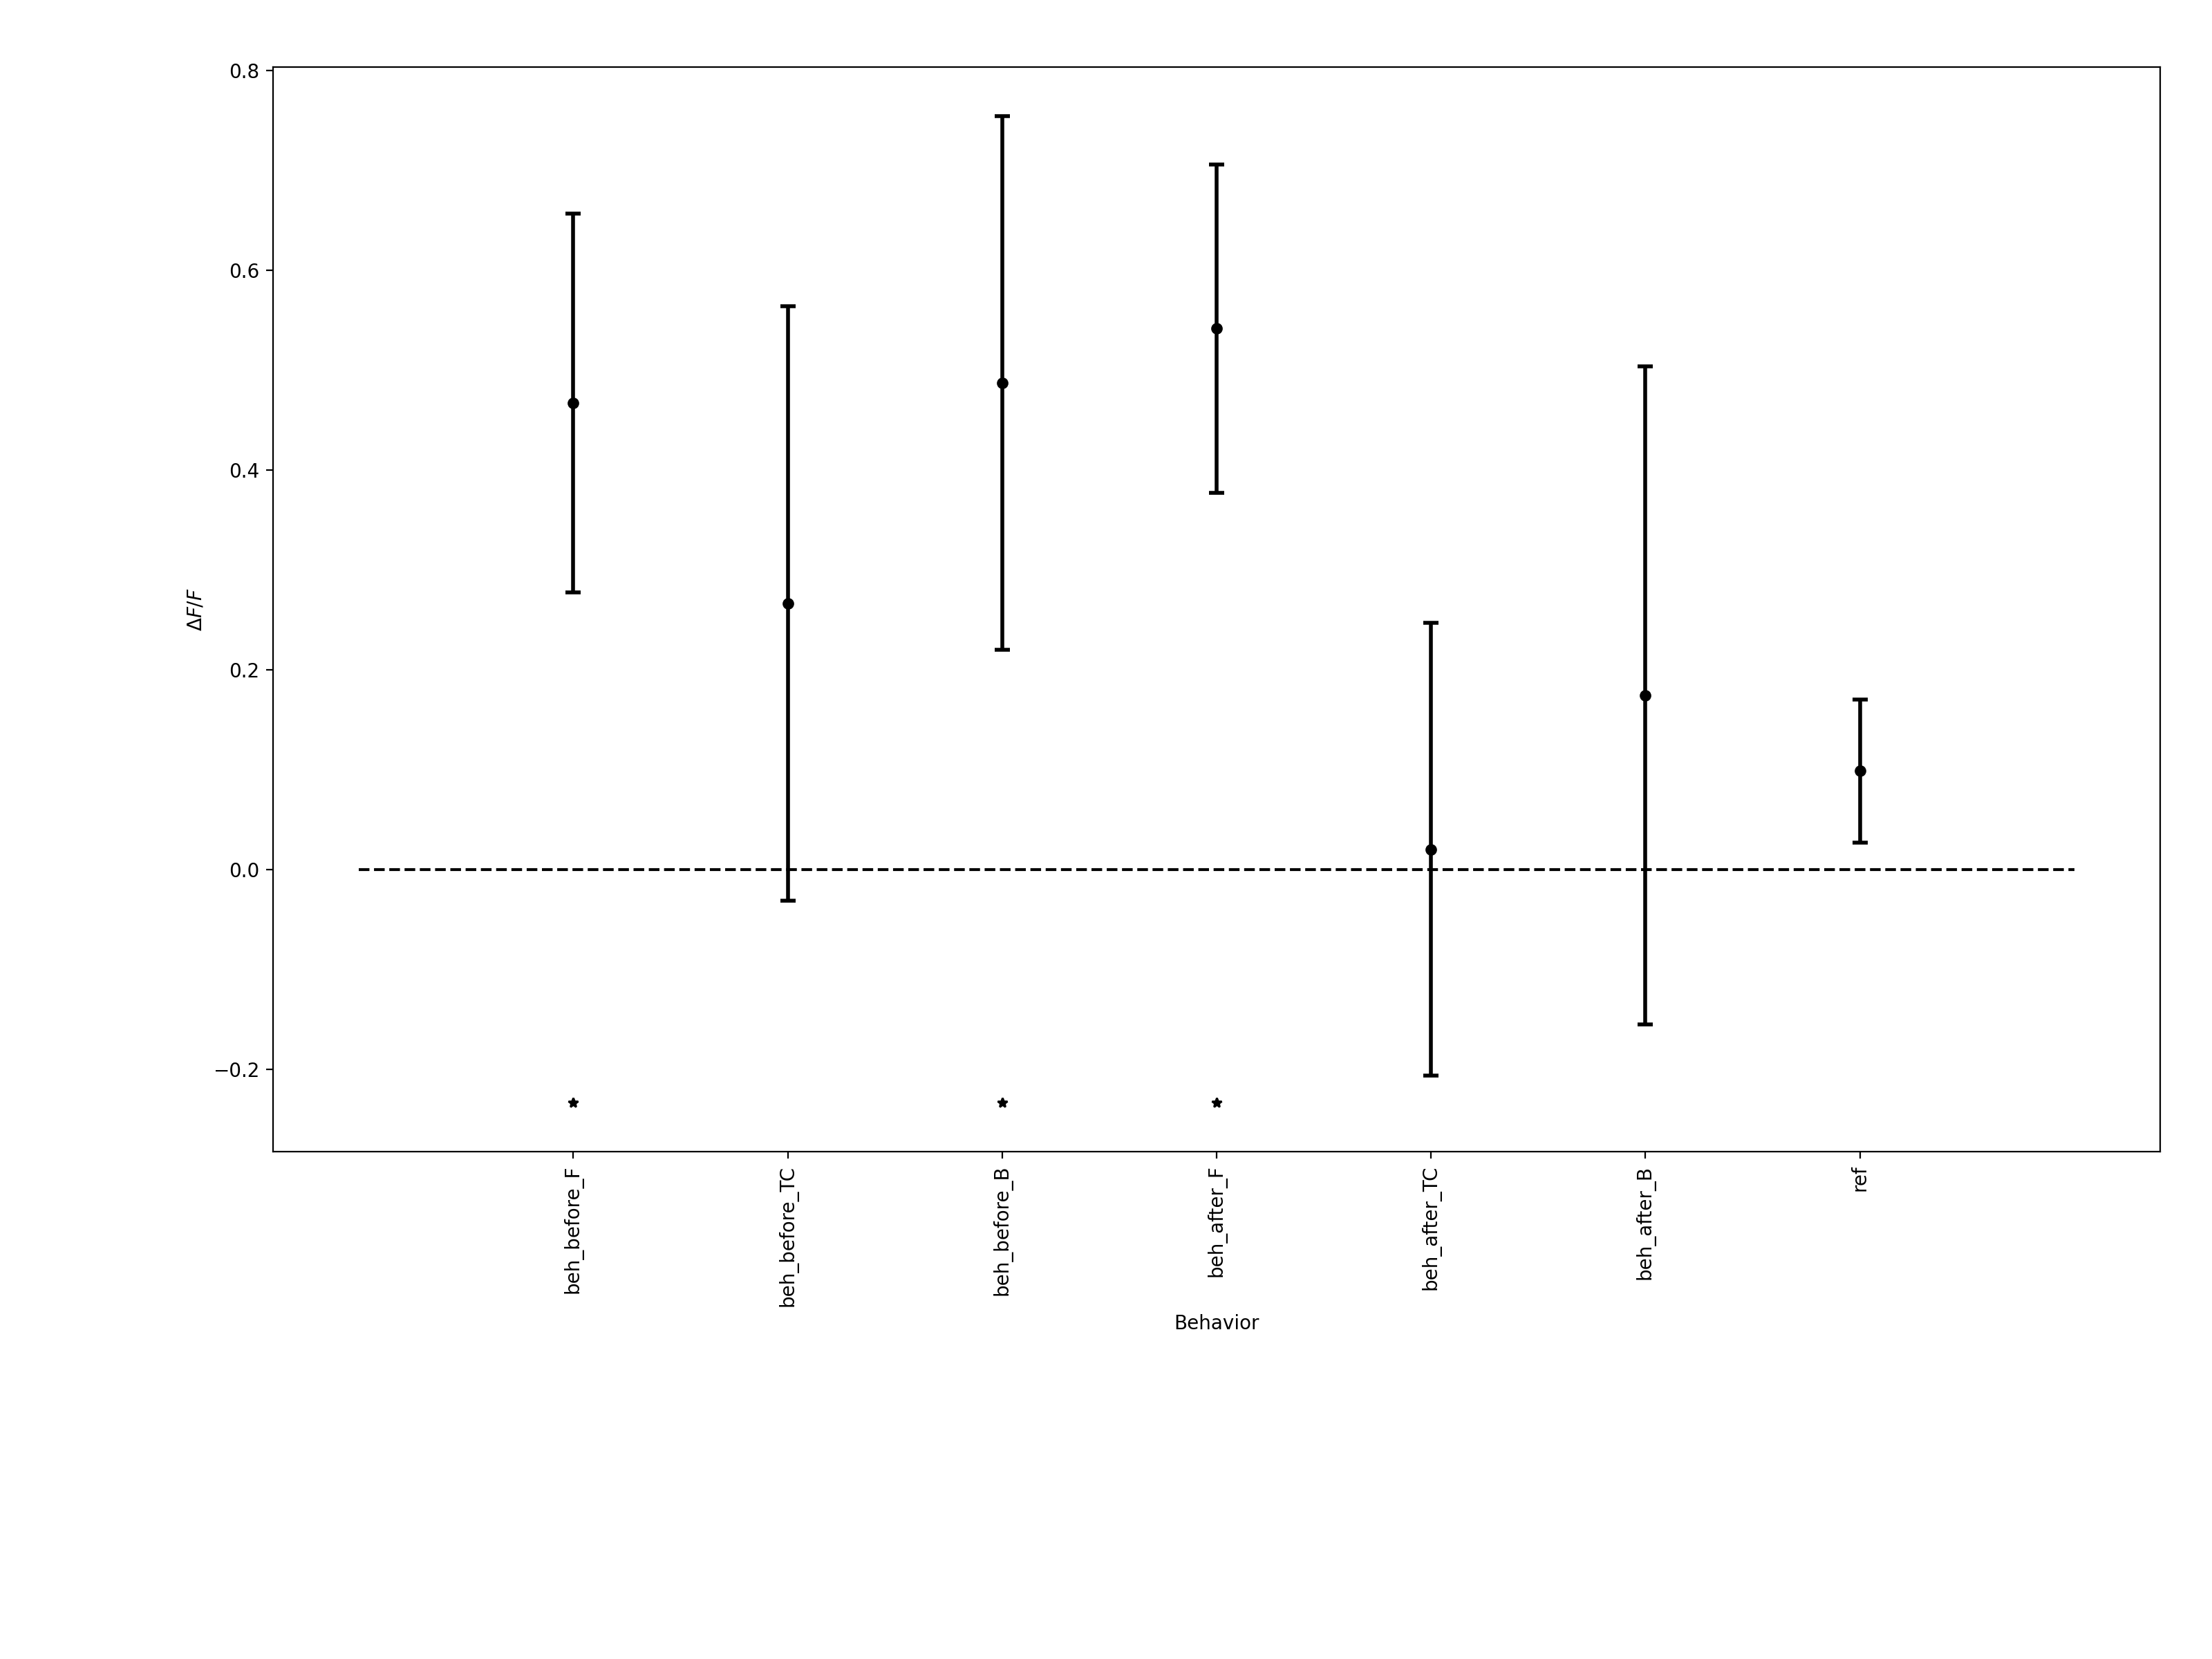

In [23]:
visualize_coefficient_stats(var_strs=vis_stats['all_behs'], theta=vis_stats['all_beta'], 
                            c_ints=vis_stats['all_c_ints'], sig=adjusted_sa_sig,
                            x_axis_rot=90)
plt.ylabel('$\Delta F / F$')
plt.xlabel('Behavior')
plt.tight_layout()
fig = plt.gcf()
fig.set_size_inches(8, 6)

## Save results out in excel format - this is to enable sharing with Chen

In [24]:
with pd.ExcelWriter(save_file, engine='openpyxl') as writer: 
    beta_tbl.to_excel(writer, sheet_name='all_tests_coefs')
    abs(adj_p_vl_tbl).to_excel(writer, sheet_name='all_tests_p_values')
    c_int_tbl.to_excel(writer, 'all_tests_confidence_intervals')